# Exercise 2:  k-Nearest Neighbors (k-NN) Classifier using the Iris dataset

Implement k-NN from scratch (no sklearn classifier), do the 70/30 split, repeat 30 times for k = 3, 7, 11, produce a boxplot of accuracies, and show one confusion matrix per k. Every cell has clear comments.

In [17]:
# Cell 1 — imports
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import datasets               # only used to load the Iris dataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
%matplotlib inline


### Load Iris dataset and prepare features/labels

In [18]:
# Cell 2 — load Iris from sklearn (simple data loader)
iris = datasets.load_iris()
X = iris.data          # shape (150,4)
y = iris.target        # values 0,1,2 (Iris-setosa, versicolor, virginica)
feature_names = iris.feature_names
class_names = iris.target_names

print("Features shape:", X.shape)
print("Classes:", class_names)


Features shape: (150, 4)
Classes: ['setosa' 'versicolor' 'virginica']


### Helper functions: Euclidean distance, k-NN predict (single sample), and batch predict

In [19]:
# Cell 3 — helper functions for k-NN (implemented from scratch)

def euclidean(a, b):
    """Euclidean distance between two 1-D arrays or lists."""
    return math.sqrt(sum((float(x)-float(y))**2 for x, y in zip(a, b)))

def knn_predict_single(x_query, X_train, y_train, k):
    """
    Predict label for a single query point by majority vote among k nearest neighbors.
    Tie-breaking: choose the class with smallest average distance among tied classes.
    """
    # compute distances to all train points
    distances = [(euclidean(x_query, x_train), y) for x_train, y in zip(X_train, y_train)]
    distances.sort(key=lambda t: t[0])
    k_nearest = distances[:k]
    labels = [lbl for _, lbl in k_nearest]
    vote_counts = Counter(labels)
    most_common = vote_counts.most_common()
    # if unique winner, return it
    top_count = most_common[0][1]
    top_labels = [lbl for lbl, cnt in most_common if cnt == top_count]
    if len(top_labels) == 1:
        return top_labels[0]
    # tie-breaker: choose label among tied ones with smallest average distance
    avg_dists = {}
    for label in top_labels:
        dists = [dist for dist, lbl in k_nearest if lbl == label]
        avg_dists[label] = sum(dists)/len(dists)
    return min(avg_dists.items(), key=lambda p: p[1])[0]

def knn_predict_batch(X_test, X_train, y_train, k):
    """Predict labels for multiple test examples."""
    preds = [knn_predict_single(xq, X_train, y_train, k) for xq in X_test]
    return np.array(preds)


### Train/test split (random 70%/30%) helper

In [20]:
# Cell 4 — helper to produce a random 70/30 split (no stratification to keep it simple)
def random_split(X, y, train_frac=0.7, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_train = int(n * train_frac)
    train_idx = idx[:n_train]
    test_idx  = idx[n_train:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


### Quick smoke test of knn on one split (k=3)

In [21]:
# Cell 5 — smoke test: one split, k=3
X_train, X_test, y_train, y_test = random_split(X, y, train_frac=0.7, seed=0)
k = 3
y_pred = knn_predict_batch(X_test, X_train, y_train, k)
print("Accuracy (one test):", accuracy_score(y_test, y_pred))
print("Sample classification report:\n", classification_report(y_test, y_pred, target_names=class_names))


Accuracy (one test): 0.9555555555555556
Sample classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        17
  versicolor       1.00      0.88      0.93        16
   virginica       0.86      1.00      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



### Main experiment: repeat 30 times for different k values and collect accuracies

In [22]:
# Cell 6 — run experiment 30 times for k in {3,7,11}
ks = [3, 7, 11]
n_repeats = 30
results = {k: [] for k in ks}

# We'll also keep one representative confusion matrix per k (the first run)
representative_confusion = {}

for k in ks:
    for run in range(n_repeats):
        seed = run  # use run index as seed so experiments are reproducible
        X_train, X_test, y_train, y_test = random_split(X, y, train_frac=0.7, seed=seed)
        y_pred = knn_predict_batch(X_test, X_train, y_train, k)
        acc = accuracy_score(y_test, y_pred)
        results[k].append(acc)
        # store first confusion matrix for this k
        if run == 0:
            representative_confusion[k] = confusion_matrix(y_test, y_pred)

# Print summary statistics
for k in ks:
    arr = np.array(results[k])
    print(f"k={k}: mean accuracy={arr.mean():.4f}, std={arr.std():.4f}, min={arr.min():.4f}, max={arr.max():.4f}")


k=3: mean accuracy=0.9593, std=0.0237, min=0.9111, max=1.0000
k=7: mean accuracy=0.9637, std=0.0226, min=0.9111, max=1.0000
k=11: mean accuracy=0.9667, std=0.0205, min=0.9111, max=1.0000


### Boxplot comparing accuracies for k = 3,7,11

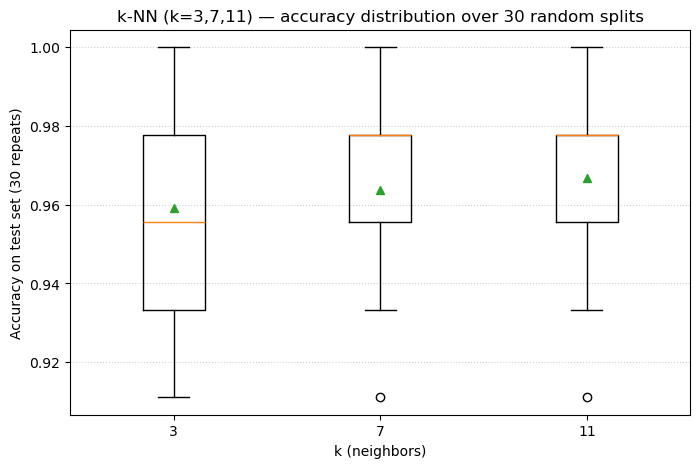

In [23]:
# Cell 7 — boxplot to compare accuracies

plt.figure(figsize=(8,5))
data_to_plot = [results[k] for k in ks]
plt.boxplot(data_to_plot, tick_labels=[str(k) for k in ks], showmeans=True)
plt.xlabel("k (neighbors)")
plt.ylabel("Accuracy on test set (30 repeats)")
plt.title("k-NN (k=3,7,11) — accuracy distribution over 30 random splits")
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()


### Show representative confusion matrix for each k

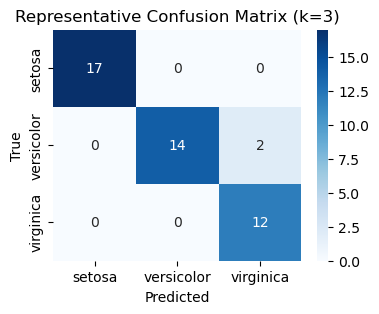

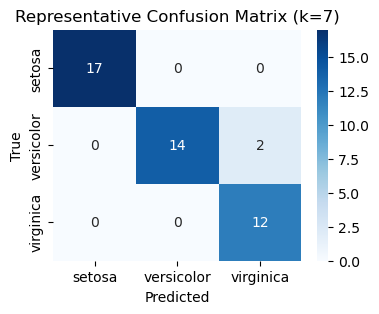

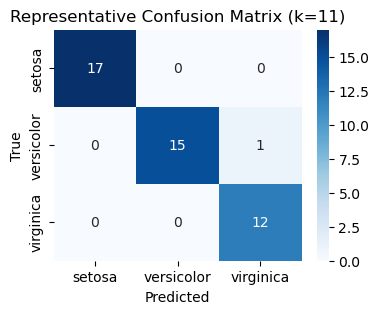

In [24]:
# Cell 8 — plot confusion matrices (one per k)
import seaborn as sns
for k in ks:
    cm = representative_confusion[k]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Representative Confusion Matrix (k={k})")
    plt.show()


### Why should k be odd?

When classifying with majority vote among k neighbors, ties can occur if k is even (e.g. 2 neighbors, 1 vote for class A and 1 for class B). Using an odd k reduces the chance of a tie when there are two classes (for multiclass ties can still occur). Fewer ties means a simpler deterministic majority rule. In practice, when the number of classes > 2 or when ties are possible due to equal votes, a tie-breaking strategy must be defined (e.g., prefer nearest neighbor among tied classes or pick class with smaller average distance). Using odd k is a simple heuristic to reduce ambiguity for binary classification cases.


#### Optional: Examples of misclassified points for best/worst run

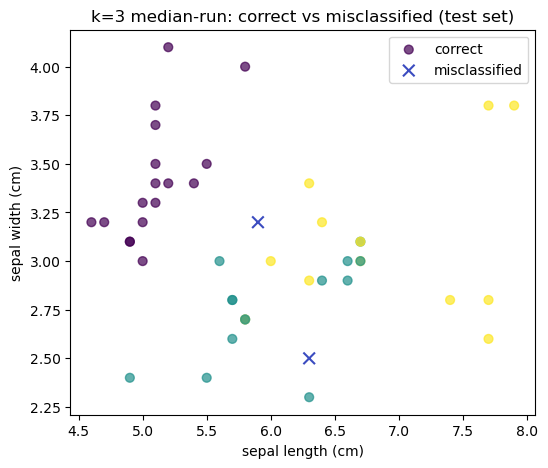

In [25]:
# Cell 10 — visualize misclassified points for the run with median accuracy for k=3 (example)
k = 3
accs = np.array(results[k])
median_run_index = int(np.argsort(accs)[len(accs)//2])  # index of median run by accuracy
seed = median_run_index
X_train, X_test, y_train, y_test = random_split(X, y, train_frac=0.7, seed=seed)
y_pred = knn_predict_batch(X_test, X_train, y_train, k)

# plot (use first two features for visualization)
plt.figure(figsize=(6,5))
correct_mask = (y_pred == y_test)
plt.scatter(X_test[correct_mask,0], X_test[correct_mask,1], c=y_test[correct_mask], cmap='viridis', marker='o', label='correct', s=40, alpha=0.7)
plt.scatter(X_test[~correct_mask,0], X_test[~correct_mask,1], c=y_test[~correct_mask], cmap='coolwarm', marker='x', label='misclassified', s=70)
plt.xlabel(feature_names[0]); plt.ylabel(feature_names[1])
plt.title(f"k={k} median-run: correct vs misclassified (test set)")
plt.legend()
plt.show()


**Notes / Checklist**
1. The k-NN classifier is implemented entirely from scratch (distance calculation, voting, tie-breaker).
2. I used sklearn.datasets only to load Iris data;
3. I used sklearn.metrics for evaluation convenience. You can compute accuracy/precision/recall manually if required.
4. The experiment runs 30 different splits (seeded) and collects accuracies for boxplot visualization.
5. The confusion matrix shown for each k is from the first repeat (representative).